In [1]:
# Sanity check: do psps events lie within NWS warnings? 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
base = '/Users/maxv/Dropbox (MIT)/inferring_expectations/'

In [2]:
nws = gpd.read_file(base + 'data/nws_gdb')
from datetime import datetime
def contime(text):
    """Convert text into a UTC datetime."""
    if text is None: return None
    # The 0000 is the standard VTEC undefined time
    if text.startswith("0000"):
        return None
    ts = datetime.strptime(text, "%Y%m%d%H%M")
    # NWS has a bug sometimes whereby 1969 or 1970s timestamps are emitted
    return ts
nws = nws[nws.PHENOM == 'FW']
nws['issued'] = nws['ISSUED'].apply(contime)
nws['expired'] = nws['EXPIRED'].apply(contime)
nws['init_exp'] = nws['INIT_EXP'].apply(contime)
nws['init_iss'] = nws['INIT_ISS'].apply(contime)
nws = nws.to_crs(epsg=2163)
nws.head()

,WFO,ISSUED,EXPIRED,INIT_ISS,INIT_EXP,PHENOM,GTYPE,SIG,ETN,STATUS,...,POLY_END,WINDTAG,HAILTAG,TORNTAG,DAMAGTAG,geometry,issued,expired,init_exp,init_iss
9811,STO,201007260000,201007260642,201007252009,201007261200,FW,C,W,2,CAN,...,None,NaN,NaN,None,None,"POLYGON ((-1724327.873 -568527.149, -1724574.4...",2010-07-26 00:00:00,2010-07-26 06:42:00,2010-07-26 12:00:00,2010-07-25 20:09:00
9812,LOX,201009260300,201009251610,201009241614,201009280400,FW,C,A,2,UPG,...,None,NaN,NaN,None,None,"POLYGON ((-1740530.663 -1015117.571, -1741649....",2010-09-26 03:00:00,2010-09-25 16:10:00,2010-09-28 04:00:00,2010-09-24 16:14:00
9813,MFR,201008171800,201008180400,201008162202,201008180400,FW,C,W,5,EXP,...,None,NaN,NaN,None,None,"POLYGON ((-1817974.743 -81926.945, -1823532.62...",2010-08-17 18:00:00,2010-08-18 04:00:00,2010-08-18 04:00:00,2010-08-16 22:02:00
9814,MFR,201008171800,201008162202,201008161041,201008180600,FW,C,A,5,UPG,...,None,NaN,NaN,None,None,"POLYGON ((-1817974.743 -81926.945, -1823532.62...",2010-08-17 18:00:00,2010-08-16 22:02:00,2010-08-18 06:00:00,2010-08-16 10:41:00
9815,MFR,201007251800,201007241757,201007222100,201007261200,FW,C,A,1,UPG,...,None,NaN,NaN,None,None,"POLYGON ((-1817974.743 -81926.945, -1823532.62...",2010-07-25 18:00:00,2010-07-24 17:57:00,2010-07-26 12:00:00,2010-07-22 21:00:00


In [3]:
np.min(nws.issued)

Timestamp('2006-04-14 07:05:00')

In [68]:
from dateutil import parser
psps = gpd.read_file(base + 'data/psps_events/')
# psps = psps.to_crs(epsg=2163)
# def psps_time(text):
#     """Convert text into a UTC datetime."""
#     if text is None: return None
#     # The 0000 is the standard VTEC undefined time
#     if text.startswith("0000"):
#         return None
#     ts = datetime.strptime(text, "%m/%d/%y%H:%M:%S+00:00")
#     # NWS has a bug sometimes whereby 1969 or 1970s timestamps are emitted
#     return ts.date()
def psps_time(text):
    return parser.parse(text, dayfirst=False)
psps['start_datetime'] = psps['Outage Sta'].apply(psps_time)
psps['start_date'] = psps['start_datetime'].dt.date
psps['start_year'] = psps['start_datetime'].dt.year
psps['restore_datetime'] = psps['Full Resto'].apply(psps_time)
psps['restore_date'] = psps['restore_datetime'].dt.date
psps['restore_year'] = psps['restore_datetime'].dt.year
psps.head()

,clean_name,Utility,Outage Sta,Full Resto,Outage Dur,Outage Day,Outage Hou,Circuit Na,HFTD,TOTAL CUST,...,MEDICAL BA,OTHER CUST,Notes,geometry,start_datetime,start_date,start_year,restore_datetime,restore_date,restore_year
0,accent,SCE,1/19/21 12:40,1/19/21 21:54,"0 days,9 hrs,13 min",0.385,9.23,ACCENT,T2,1584,...,81,0,None,"MULTILINESTRING ((-1579980.231 -1073143.190, -...",2021-01-19 12:40:00,2021-01-19,2021,2021-01-19 21:54:00,2021-01-19,2021
1,acosta,SCE,10/10/19 8:14,10/12/19 10:05,"2 days,1 hrs,51 min",2.077,49.85,ACOSTA,Tier 2/Tier 3,5,...,0,0,None,"MULTILINESTRING ((-1601640.205 -1036273.404, -...",2019-10-10 08:14:00,2019-10-10,2019,2019-10-12 10:05:00,2019-10-12,2019
2,acosta,SCE,10/24/19 4:48,10/25/19 14:28,"1 days,9 hrs,40 min",1.403,33.67,Acosta 12kV,Tier 2/Tier 3,1243,...,36,99,None,"MULTILINESTRING ((-1601640.205 -1036273.404, -...",2019-10-24 04:48:00,2019-10-24,2019,2019-10-25 14:28:00,2019-10-25,2019
3,acosta,SCE,10/28/19 6:49,10/29/19 9:55,"1 days,3 hrs,6 min",1.129,27.10,ACOSTA,None,1243,...,36,None,None,"MULTILINESTRING ((-1601640.205 -1036273.404, -...",2019-10-28 06:49:00,2019-10-28,2019,2019-10-29 09:55:00,2019-10-29,2019
4,acosta,SCE,10/30/19 1:30,11/1/19 11:53,"2 days,10 hrs,23 min",2.433,58.38,ACOSTA,None,1243,...,36,None,None,"MULTILINESTRING ((-1601640.205 -1036273.404, -...",2019-10-30 01:30:00,2019-10-30,2019,2019-11-01 11:53:00,2019-11-01,2019


<AxesSubplot:>

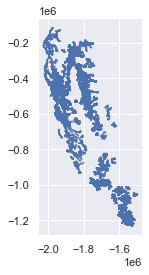

In [69]:
psps.plot()

In [70]:
psps[psps.Utility == 'PGE'].head()

,clean_name,Utility,Outage Sta,Full Resto,Outage Dur,Outage Day,Outage Hou,Circuit Na,HFTD,TOTAL CUST,...,MEDICAL BA,OTHER CUST,Notes,geometry,start_datetime,start_date,start_year,restore_datetime,restore_date,restore_year
1869,alhambra 1105,PGE,10/26/19 20:19,10/28/19 20:44,"2 days,0 hrs,25 min",2.017,48.42,ALHAMBRA-1105*,"TIER 3, TIER 2, PARTIALLY OUTSIDE HFTD",1712,...,80,4,None,"MULTILINESTRING ((-1915149.356 -524735.118, -1...",2019-10-26 20:19:00,2019-10-26,2019,2019-10-28 20:44:00,2019-10-28,2019
1870,alleghany 1101,PGE,10/9/19 3:31,10/12/19 12:57,"3 days,9 hrs,26 min",3.393,81.43,ALLEGHANY-1101,"TIER 2, TIER 3, PARTIALLY OUTSIDE HFTD",1038,...,12,4,None,"MULTILINESTRING ((-1764271.278 -380795.455, -1...",2019-10-09 03:31:00,2019-10-09,2019,2019-10-12 12:57:00,2019-10-12,2019
1871,alleghany 1101,PGE,10/23/19 16:26,10/24/19 20:02,"1 days,3 hrs,36 min",1.150,27.60,ALLEGHANY-1101,"TIER 3, TIER 2, PARTIALLY OUTSIDE HFTD",1037,...,12,2,None,"MULTILINESTRING ((-1764271.278 -380795.455, -1...",2019-10-23 16:26:00,2019-10-23,2019,2019-10-24 20:02:00,2019-10-24,2019
1872,alleghany 1101,PGE,10/26/19 18:24,10/31/19 16:05,"4 days,21 hrs,41 min",4.903,117.68,ALLEGHANY-1101,"TIER 3, TIER 2, PARTIALLY OUTSIDE HFTD",1034,...,12,2,None,"MULTILINESTRING ((-1764271.278 -380795.455, -1...",2019-10-26 18:24:00,2019-10-26,2019,2019-10-31 16:05:00,2019-10-31,2019
1873,alleghany 1101,PGE,9/7/20 21:57,9/10/20 16:31,"2 days,18 hrs,34 min",2.774,66.57,ALLEGHANY 1101,"Partially Outside HFTD, Tier 3, Tier 2",1028,...,22,2,None,"MULTILINESTRING ((-1764271.278 -380795.455, -1...",2020-09-07 21:57:00,2020-09-07,2020,2020-09-10 16:31:00,2020-09-10,2020


In [19]:
# (nws.init_iss.dt.date <= date) | (nws.issued.dt.date <= date)
np.minimum(nws.init_iss.dt.date, nws.issued.dt.date)

0       2021
1       2019
2       2019
3       2019
4       2019
        ... 
4444    2019
4445    2019
4446    2020
4447    2018
4448    2017
Name: datetime, Length: 4449, dtype: int64

In [71]:
VTEC_SIGNIFICANCE = {
"W": "Warning",
"Y": "Advisory",
"A": "Watch",
"S": "Statement",
"O": "Outlook",
"N": "Synopsis",
"F": "Forecast",
}
warning_anywhere = []
warning_exists = []
fire_warnings = []
# Merging data into fire records
# Did the fire start in fire weather warning conditions? 
# Look at that distribution over time (since 2006 at least)
# What does this capture? Controlling for some significant weather variation, do we still see changes in fire size over time? 
# That's indicative of the overall extent of climate change, actually quite a bit. 
# Also plot how the distribution of fire dates has shifted - maybe have as a histogram on the bottom? (share of fires in which one) 
for i, row in psps.iterrows(): 
    start_date = row['start_date']
    restore_date = row['restore_date']
    records_subset = nws[(np.minimum(nws.init_iss.dt.date, nws.issued.dt.date) <= restore_date)  &\
                         (np.maximum(nws.init_exp.dt.date, nws.expired.dt.date) >= start_date)]
#     (nws.init_exp.dt.date >= date) | (nws.expired.dt.date >= date))]
    if len(records_subset) == 0: 
        fire_warnings.append(None)
        warning_exists.append(0)
        warning_anywhere.append(0)
        continue
    warning_anywhere.append(1)
    records_subset = records_subset[records_subset.intersects(row.geometry)]
    if len(records_subset) == 0: 
        fire_warnings.append(None)
        warning_exists.append(0)
        continue
    warnings=pd.unique(records_subset.SIG)
    warning_exists.append(1)
    if 'W' in warnings: 
        fire_warnings.append('W')
    elif 'Y' in warnings:
        fire_warnings.append('Y')
    elif 'A' in warnings:
        fire_warnings.append('A')
    elif 'S' in warnings:
        fire_warnings.append('S')
    else:
        assert False, "fire warning category not found"
psps['warning_anywhere'] = warning_anywhere
psps['warning_exists'] = warning_exists
psps['fire_warning'] = fire_warnings


In [81]:
np.mean(warning_anywhere)

0.9948652118100129

In [75]:
psps[(psps.Utility == 'PGE') & (psps.warning_exists == 0)]

,clean_name,Utility,Outage Sta,Full Resto,Outage Dur,Outage Day,Outage Hou,Circuit Na,HFTD,TOTAL CUST,...,geometry,start_datetime,start_date,start_year,restore_datetime,restore_date,restore_year,warning_anywhere,warning_exists,fire_warning
1960,arcata 1105,PGE,10/9/19 3:31,10/10/19 2:37,"0 days,23 hrs,6 min",0.963,23.10,ARCATA-1105,NON HFTD,3997,...,"MULTILINESTRING ((-1990376.218 -156218.172, -1...",2019-10-09 03:31:00,2019-10-09,2019,2019-10-10 02:37:00,2019-10-10,2019,1,0,None
1961,arcata 1105,PGE,10/26/19 22:26,10/28/19 16:24,"1 days,17 hrs,58 min",1.749,41.97,ARCATA-1105,NON-HFTD,3954,...,"MULTILINESTRING ((-1990376.218 -156218.172, -1...",2019-10-26 22:26:00,2019-10-26,2019,2019-10-28 16:24:00,2019-10-28,2019,1,0,None
1962,arcata 1106,PGE,10/9/19 3:32,10/10/19 2:42,"0 days,23 hrs,10 min",0.965,23.17,ARCATA-1106,NON HFTD,1478,...,"MULTILINESTRING ((-1990572.124 -161511.814, -1...",2019-10-09 03:32:00,2019-10-09,2019,2019-10-10 02:42:00,2019-10-10,2019,1,0,None
1963,arcata 1106,PGE,10/26/19 22:18,10/28/19 14:40,"1 days,16 hrs,22 min",1.682,40.37,ARCATA-1106,NON-HFTD,1469,...,"MULTILINESTRING ((-1990572.124 -161511.814, -1...",2019-10-26 22:18:00,2019-10-26,2019,2019-10-28 14:40:00,2019-10-28,2019,1,0,None
1964,arcata 1121,PGE,10/9/19 2:30,10/10/19 1:41,"0 days,23 hrs,11 min",0.966,23.18,ARCATA-1121,"TIER 2, PARTIALLY OUTSIDE HFTD",2713,...,"MULTILINESTRING ((-1990558.922 -164091.704, -1...",2019-10-09 02:30:00,2019-10-09,2019,2019-10-10 01:41:00,2019-10-10,2019,1,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4163,willow creek 1102,PGE,10/9/19 2:17,10/10/19 11:53,"1 days,9 hrs,36 min",1.400,33.60,WILLOW CREEK-1102,"TIER 2, TIER 3, PARTIALLY OUTSIDE HFTD",133,...,"MULTILINESTRING ((-1952568.142 -165108.974, -1...",2019-10-09 02:17:00,2019-10-09,2019,2019-10-10 11:53:00,2019-10-10,2019,1,0,None
4165,willow creek 1103,PGE,10/9/19 2:10,10/10/19 12:32,"1 days,10 hrs,22 min",1.432,34.37,WILLOW CREEK-1103,"TIER 2, PARTIALLY OUTSIDE HFTD",1429,...,"MULTILINESTRING ((-1952361.515 -167719.883, -1...",2019-10-09 02:10:00,2019-10-09,2019,2019-10-10 12:32:00,2019-10-10,2019,1,0,None
4181,wood 0401,PGE,10/26/19 20:11,10/29/19 12:46,"2 days,16 hrs,35 min",2.691,64.58,WOOD-0401,"TIER 2, PARTIALLY OUTSIDE HFTD",86,...,"MULTILINESTRING ((-1927068.961 -537828.419, -1...",2019-10-26 20:11:00,2019-10-26,2019,2019-10-29 12:46:00,2019-10-29,2019,1,0,None
4191,woodside 1102,PGE,10/26/19 21:56,10/28/19 18:22,"1 days,20 hrs,26 min",1.851,44.43,WOODSIDE-1102*,"TIER 2, PARTIALLY OUTSIDE HFTD",111,...,"MULTILINESTRING ((-1938365.483 -578536.938, -1...",2019-10-26 21:56:00,2019-10-26,2019,2019-10-28 18:22:00,2019-10-28,2019,1,0,None


In [73]:
nws['year'] = nws.init_iss.dt.year
nws.groupby('year').count()

,WFO,ISSUED,EXPIRED,INIT_ISS,INIT_EXP,PHENOM,GTYPE,SIG,ETN,STATUS,...,POLY_END,WINDTAG,HAILTAG,TORNTAG,DAMAGTAG,geometry,issued,expired,init_exp,init_iss
year,,,,,,,,,,,,,,,,,,,,,
2006,615,615,615,615,615,615,615,615,615,615,...,0,0,0,0,0,615,615,615,615,615
2007,1039,1039,1039,1039,1039,1039,1039,1039,1039,1039,...,0,0,0,0,0,1039,1039,1039,1039,1039
2008,793,793,793,793,793,793,793,793,793,793,...,0,0,0,0,0,793,793,793,793,793
2009,413,413,413,413,413,413,413,413,413,413,...,0,0,0,0,0,413,413,413,413,413
2010,214,214,214,214,214,214,214,214,214,214,...,0,0,0,0,0,214,214,214,214,214
2011,356,356,356,356,356,356,356,356,356,356,...,0,0,0,0,0,356,356,356,356,356
2012,531,531,531,531,531,531,531,531,531,531,...,0,0,0,0,0,531,531,531,531,531
2013,579,579,579,579,579,579,579,579,579,579,...,0,0,0,0,0,579,579,579,579,579
2014,759,759,759,759,759,759,759,759,759,759,...,0,0,0,0,0,759,759,759,759,759
